In [83]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Python私房手册-基本语法和数据类型

## 概念和语法

### 概念

#### 什么是可哈希

之前看书总是看到一句话就是不可变对象是可哈希的，可变对象是不可哈希的。总是不明白这个哈希到底是个什么东西，其实说白了，哈希值是人为定义的，如果一个对象有`__hash__`方法，这个方法能返回一个整数值，则这个对象就是可哈希的，如果没有这个方法，就是不可哈希的。一般都是根据专门的哈希算法算出来的。

为什么所有对象需要有这样一个方法呢，需要能返回这样一个哈希值呢，其实是为了在字典和集合这样使用散列表存储数据的结构中查找数据，因为散列表查找值是根据`key`的哈希值来查找的，具体的实现细节查看《字典到底是有序还是无序》一节。简单来说，以字典为例，会先根据要查找的`key`的哈希值的其中几位计算出一个偏置，然后根据这个偏置找到散列表中的一个表元，如果表元为空，则抛出`KeyError`，如果不为空，会查看表元里面存储的`key`和要查找的`key`是不是一致，一致则返回`value`，如果不同，则发生了散列冲突，则会再从要查找的`key`的哈希值重新再取几位计算偏置，再重复以上过程。

In [84]:
class C:
    def __eq__(self, value):
        if hash(self) == hash(value):
            return True

    def __hash__(self):
        return 123456


c1 = C()
c1.name = "c1"
c2 = C()
c2.name = "c2"

c1 == c2  
c1 is c2  # is是根据id来判断的，所以c1 is not c2

True

False

In [85]:
d = {c1: 42}

d[c1]
d[c2]

42

42

如上的例子，即使`c1`和`c2`是两个不同的实例，但是由于他们的哈希值是相同的，而且相等（通过定义`__eq__`方法实现）。所以可以通过`c2`来查找`c1`。        

所以，一个不可变对象，实现了`__eq__`方法，同时需要实现`__hash__`方法，才能作为字典的键，并且要保证在`a == b`为真的情况下`hash(a) == hash(b)`也为真，这样才能实现根据相同的值，来对字典进行读取。

In [86]:
t1 = tuple((1, 2))
t2 = tuple((1, 2))

d = {t1: "t1"}
d
d[t2]

{(1, 2): 't1'}

't1'

而一个可变对象，不是说不能实现`__hash__`方法，而是没法实现哈希值也相同的时候，值一定相同，这就破坏了现有的查找的原则：

In [87]:
from collections import UserList


class MyList(UserList):
    def __hash__(self):
        return id(self)


mylist1 = MyList([1, 2, 3])
d = {mylist1: "I am mylist"}
d

{[1, 2, 3]: 'I am mylist'}

In [88]:
import traceback

mylist2 = MyList([1, 2, 3])
try:
    d[mylist2]
except KeyError:
    traceback.print_exc()

Traceback (most recent call last):
  File "C:\Users\admin\AppData\Local\Temp/ipykernel_18352/1521460084.py", line 5, in <module>
    d[mylist2]
KeyError: [1, 2, 3]


#### 作用域 

在学javascipt的时候，突然发现对于作用域还是很多细节是不了解的，同时在python中进行对比测试，结论如下：
1. python的作用域和javascript一样，是词法作用域，写代码时进行静态确定。而动态作用域则是在运行时被动态确定。如下，`print(a)`会在当前作用域下查找变量，找不到`a`，则继续在全局作用域中查找，此时的`a`是全局变量。

In [89]:
def foo():
    print(a)
    
def bar():
    a = 3
    foo()
    
a = 2
bar()  # 输出为2，因为a在定义时在foo的作用域，foo作用域没有定义a，则会继续查找外层作用域，即为全局的变量a=2

2


2. 很容易把动态作用域和嵌套作用域弄混。如下的代码其实是嵌套作用域：

In [90]:
def bar():
    def foo():
        print(a)
    a = 2
    foo()
    
a = 3
bar()

2


3. 嵌套作用域很容易犯的一个错误就是在赋值之前引用，javascript的术语叫做暂时性死区：

In [91]:
def bar():
    def foo():
        print(a)
    foo()
    a = 2
    
a = 3
try:
    bar()
except NameError as e:
    print(e)

free variable 'a' referenced before assignment in enclosing scope


### 语法

#### 括号里的不同行字符串

括号里的字符串可以不在一行上，`python`默认会将其合并，注意中间不能加逗号：

In [92]:
text1 = ('a' 
         'b')
text2 = 'ab'
type(text1)
text1 == text2
print(text1)

str

True

ab


#### 关于`exec`

`exec()`可以执行字符串形式的语句，但是要注意的是它在局部范围中的行为，主要有两点：
1. 在局部范围内，总是收集所有的局部变量，组成一个字典传递给`exec`，也就是说传递给`exec`的并不是实际的局部变量，而是一个副本。
2. 每次运行`locals()`方法，就相当于重新收集一次所有的局部变量。

In [93]:
def func():
    a = 12
    exec("b = a + 2")
    print(b)

func()

bytearray(b'bb')


如上，在函数范围内，其实并没有`b`变量。可以这样做：

In [94]:
def func():
    a = 12
    loc = locals()
    exec("b = a + 2")
    b = loc['b']  # 不能使用locals()['b']，因为此时运行locals()会又一次收集函数的局部变量更新副本，函数的局部变量没有b, 相当于覆盖掉现有副本
    print(b)

func()

14


注意，`locals()`返回的也是局部范围内所有变量构成的字典的副本，和传入`exec`的是同一个，并不会运行`locals()`的时候产生一个副本，执行`exec`的时候又产生一个副本。同时要注意，每次运行`locals()`方法，会收集当前的所有局部变量更新这个副本（始终只有一个副本）：

In [95]:
def func():
    a = 12
    loc = locals()
    print(loc)
    exec("a += 2")
    print(loc)
    locals()
    print(loc)

func()

{'a': 12}
{'a': 14, 'loc': {...}}
{'a': 12, 'loc': {...}}


如果这样的行为让你疑惑，可以使用`exec`的后两个参数明确的传递表示作用域的字典给它，`exec`只会操作这个字典里的变量，不会影响到实际的变量：

In [96]:
def func():
    a = 12
    loc = {"a": a}
    exec("a += 2", {}, loc)
    print(loc['a'])
    print(a)
    
func()

14
12


#### 逻辑值检测

和javascript不同，python的逻辑值检测基本上不太会出错，很符合人的直觉。以下为官网的说明：

任何对象都可以进行逻辑值的检测，以便在`if`或`while`作为条件或是作为下文所述布尔运算的操作数来使用。一个对象在默认情况下均被视为真值，除非当该对象被调用时其所属类定义了`__bool__()`方法且返回`False`或是定义了`__len__()`方法且返回零。下面基本完整地列出了会被视为假值的内置对象:
1. 被定义为假值的常量: `None`和`False`。
2. 任何数值类型的零: `0`, `0.0`, `0j`, `Decimal(0)`, `Fraction(0, 1)`
3. 空的序列和多项集: `''`, `()`, `[]`, `{}`, `set()`, `range(0)`

产生布尔值结果的运算和内置函数总是返回`0`或`False`作为假值，`1`或`True`作为真值。

这里列举出来主要是为了说明，在`python`中，如果要判断是否为`[]`列表，pythonic的做法是：

In [97]:
a = []
if a:
    print("a list with elements")
else:
    print("empty list")

empty list


而不是一些教程看到的或者类似其它语言的写法：

In [98]:
a = []
if len(a) != 0:
    print("a list with elements")
else:
    print("empty list")

empty list


#### 运算符优先级

- [《Python运算符优先级和结合性一览表》](http://www.runoob.com/python/python-operators.html)

简单来说就是 计算运算符>移位运算符>关系运算符>逻辑运算符>赋值运算符

#### 利用&判断奇偶

`&`是位运算符，指按位与，奇数二进制最后一位为1，与1按位与以后最低位为1，其它位为0，因此奇数为1（`True`），偶数为0（`False`）：

In [99]:
def fun(x):
    return True if x & 1 else False

5 & 1
4 & 1
sum(filter(fun, range(5)))

1

0

4

#### with语句

`with`比较好理解，就是后面接一个有`__enter__`和`__exit__`类的实例，不过有几点要注意：
1. 当在`with`内部代码块里面抛出异常，会传递到`__exit__`中，此时需要返回`True`告诉解释器，异常已经处理，否则异常会向上冒泡：

In [138]:
class C:
    def __enter__(self):
        pass
    def __exit__(self, exc_type, exc_value, traceback):
        if exc_type is not None:
            print(f"{exc_value}")

with C():
    raise TypeError("type error")

type error


TypeError: type error

In [139]:
class C:
    def __enter__(self):
        pass
    def __exit__(self, exc_type, exc_value, traceback):
        if exc_type is not None:
            print(f"{exc_value}")
            return True

with C():
    raise TypeError("type error")

type error


2. `contextlib.context.manager`装饰器装饰一个生成器时，最佳实践是将`yield`语句放在`try...except...finally`中间，来捕获`with`内部抛出的异常，如果要向上冒泡，需要在`except`中主动将异常再次抛出。

In [140]:
from contextlib import contextmanager

@contextmanager
def with_demo():
    try:
        yield
    except Exception as e:
        print(e)
        
with C():
    raise TypeError("type error")

type error


In [141]:
from contextlib import contextmanager

@contextmanager
def with_demo():
    try:
        yield
    except Exception as e:
        print(e)
        raise e
        
with with_demo():
    raise TypeError("type error")

type error


TypeError: type error

#### 列表和元组+=的差别

元组和列表的`+=`操作有一个细微但是重要的差别，列表的`+=`是在原列表上修改，而元组因为是不可变的，返回一个新的元组，如：

In [142]:
a = [1, 2, 3]
b = a
a += [4, 5]  # 在原列表a上修改
a
b

[1, 2, 3, 4, 5]

[1, 2, 3, 4, 5]

In [143]:
a = 1, 2, 3
b = a
a += 4, 5 # 返回一个新的元组，重新给变量a赋值
a
b

(1, 2, 3, 4, 5)

(1, 2, 3)

## 数据类型

### 数字

#### 较小整数值的重用

- [关于python整数重用的两个问题](https://blog.csdn.net/qq_49531959/article/details/112093678)

首先，当给变量赋值的时候，python首先会创建一个新的值，然后把这个值的内存地址赋值给变量。比如：

In [144]:
a = 555  # 内存中创建一个值
id(a)    # 把这个值的引用赋值给变量a

2310507568464

In [145]:
a = 555  # 内存中创建一个新的555
id(a)    # 新的引用赋值给变量a，因此两次地址不同

2310507569040

但是一些较小的整数，python内部进行了优化，他在内存中始终保存着一些较小的整数，当有变量赋值时，直接把这些小的整数的地址赋值给变量：

In [146]:
z = []
for i in range(-1000, 1000):
    for j in range(-1000, 1000):
        if id(i) == id(j):
            z.append(i)
print([z[0], z[-1]])

[-5, 256]


可见，3.7版本中，-5到256之间的整数地址是不变的。

### 字符串

#### unicode原理

- [字符编码笔记：ASCII，Unicode 和 UTF-8](http://www.ruanyifeng.com/blog/2007/10/ascii_unicode_and_utf-8.html)
- [刨根究底字符编码系列](https://blog.csdn.net/liangtaox8/article/list/3)
- [unicode之痛](https://pycoders-weekly-chinese.readthedocs.io/en/latest/issue5/unipain.html#python-3)

之前一直对各种编码转换搞不清楚，`encode`和`decode`老是弄混，突然有一天就想明白了：~~可以把显示的各种字符，也就是你看到的文字，字母想象成一副图画。而计算机只能存储一些二进制的数字，所以在计算机里面保存了一张巨大的字典，其中键是数字，值就是这些图画。这些数字就是所谓的unicode编码，打印字符其实就是在这个巨大的字典表里面根据数字找到这些图画，然后显示出来。~~上述的描述不够准确，输入法使用的是什么编码呢？是操作系统的默认编码吗？

`unicode`中最大的数字，如果用二进制来表示的话，需要32位bit才行，如果直接在电脑里面保存这些数字，每一个字符就需要使用32bit4个字节。你可能会想，为什么每个字符都使用32bit呢，就用每个数字的二进制来表示不好吗？但是这样的话，如果是连续的多个字符，计算机无法知道如何区分字符。如果都用32bit表示一个字符，就可以每32bit一读。很明显，这样的话会非常的占空间，因此又发明了`utf8`,`utf16`,`utf32`各种编码。可以用比较少的bit数来代表一个字符，主要目的就是为了节省存储空间。

其中`utf8`是变长的，2,3,4字节不等，`utf16`也是变长，但是只能2个或者4个字节，小于65535的用2个字节，大于的用4个字节。而`utf32`完全等同于`unicode`数字。至此，显示一个字符的流程变为，以`utf8`为例，先根据一个字符的`utf8`编码找到对应的`unicode`编码，也就是字典表里的键，然后根据键找到对应的字符，然后再显示出来。

几个知识点：
1. 类似`utf8`,`utf16`，python中`unicode`编码使用`unicode_escape`表示。
2. `\u`开头的字符串是用`unicode`编码数字表示的字符，其编码数字小于65535，一共4位，2个字节，大于65536用`\U`开头的字符串表示，一共8位，4个字节，不足8位前面补0。
3. 以下方法可以帮助记忆什么时候使用`encode`，什么时候使用`decode`：前面带b，表示已经是这个字符的编码，要转换成字符，也就是知道了键的数字，要获取图案，所以要使用`decode`解码。不带b，表示知道了图像，要获取键的数字，因此要编码，使用`encode`。

举个例子：

In [147]:
print('\U0001F48B')

💋


In [148]:
'💋'.encode('unicode_escape')

b'\\U0001f48b'

In [149]:
b'\\U0001f48b'.decode('unicode_escape')

'💋'

In [150]:
'💋'.encode('utf8')

b'\xf0\x9f\x92\x8b'

In [151]:
b'\xf0\x9f\x92\x8b'.decode('utf8')

'💋'

#### unicode字符的表示方法

字符串的每个字符在内部表示为unicode代码点(注意，这里的内部是指在python内部，而不是指存储在文件中，存储在文件中需要指定某种编码，编码和unicode码点是一一对应关系，主要是为了节省存储空间)，每个代码点对应的字符[这里](https://unicode.org/charts/)可以查到，有几种表示方法：
1. 如果代码点的整数表示小于256，可以用1个字节可以表示，则可以用`\x`表示，比如:

In [152]:
'\xf1'

'ñ'

2. 如果代码点的整数表示小于65536，需要用2个字节表示，则使用`\u`表示，超过2个字节用`\U`表示，不足的前面补零。可以用高位的表示低位的，但是不能用低位的表示高位的，比如：

In [153]:
'\u00f1'

'ñ'

In [154]:
'\U000000f1'

'ñ'

3. 还有一种方法，每个unicode字符都是有名字的，可以用`\N{name}`来表示：

In [155]:
'\N{LATIN SMALL LETTER N WITH TILDE}'

'ñ'

python总是把字节码尽可能简短的表示为有意义的unicode字符，因此1个字节的情况下使用前缀使用`\x`(`\xhh`的形式)，2个字节则使用`\u`(`\uhhhh`的形式)开头，4个字节则使用`\U`开头(`\Uhhhhhhhh`的形式)。而`\x`1个字节的字节码，python会将其显示为可读的ASCII字符。所以`b'\u0053'`实际上和`b'\u53'`在数值上是一样的，但是python并不会把`\u`看成是有效的字节码前缀，而只是把简单的把`\`和`u`识别为ASCII字符。因为前缀的位数是固定的，比如`\u`必须是4位，想象一下，如果`\u53`也行，那么`\u53a4`到底是代表`\u53`还是`\u53a`还是`\u53a4`呢。

In [156]:
'\u53a4'

'厤'

In [157]:
b'\u53a4'.decode('unicode escape')

'厤'

如上，`\u`表示后面的4位字节码是一个字符，如果写成`\x53\xa4`，则python会把它当作2个字符去识别。

In [158]:
'\x53\xa4'

'S¤'

In [159]:
b'\x53\xa4'.decode('unicode escape')

'S¤'

也就是说`\u`代表2个字节一读，`\U`代表4个字节一读，`\x`代表一个字节一读。以上主要是针对`unicode escape`编码，也就是字符本身的码位。如果是`utf8`，由于已知编码，不需要确定几个字节一读，那么直接一个字节一个字节的显示就可以了。

In [160]:
'我是中国人'.encode('utf8')

b'\xe6\x88\x91\xe6\x98\xaf\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba'

#### 如果获取字符的码点或者根据码点获取字符

使用`chr`和`ord`函数即可，`ord`根据字符获取码点，`chr`根据码点获取字符：

In [161]:
ord("国")

22269

In [162]:
chr(22269)

'国'

#### 混乱的windows编码

这个问题起因是当在`cmd`中输入`python`，进入python命令行时，出现报错：
```
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)] :: Anaconda, Inc. on win32
Type "help", "copyright", "credits" or "license" for more information.
Failed calling sys.__interactivehook__
Traceback (most recent call last):
  File "D:\programs\Anaconda3\lib\site.py", line 439, in register_readline
    readline.read_history_file(history)
  File "D:\programs\Anaconda3\lib\site-packages\pyreadline\rlmain.py", line 165, in read_history_file
    self.mode._history.read_history_file(filename)
  File "D:\programs\Anaconda3\lib\site-packages\pyreadline\lineeditor\history.py", line 83, in read_history_file
    for line in open(filename, 'r'):
UnicodeDecodeError: 'gbk' codec can't decode byte 0x80 in position 2273: illegal multibyte sequence
```
很明显是编码错误，我打印了history.py文件第83行中的filename，提示是`C:\Users\18907\.python_history`的文件，这个文件保存了之前使用`python`命令行输入过的一些历史命令，查看文件的编码是`utf8`格式，说明`cmd`中`open`一个文件使用的是`gbk`编码，解决方案很简单，修改`for line in open(filename, 'r')`，加上`encoding='utf8'`，或者将`.python_hisotry`文件用记事本打开，改为`ANSI`格式，再或者删除这个文件。

不过联想到之前看《流畅的python》一书中的内容，正好对windows下的编码做个总结，直接运行《流畅的python》一书4.5节的例子，如下：

In [163]:
import sys, locale
expressions = """
locale.getpreferredencoding()
type(my_file)
my_file.encoding
sys.stdout.isatty()
sys.stdout.encoding
sys.stdin.isatty()
sys.stdin.encoding
sys.stderr.isatty()
sys.stderr.encoding
sys.getdefaultencoding()
sys.getfilesystemencoding()
"""
my_file = open('dummy', 'w')
for expression in expressions.split():
    value = eval(expression)
    print(expression.rjust(30), '->', repr(value))

 locale.getpreferredencoding() -> 'cp936'
                 type(my_file) -> <class '_io.TextIOWrapper'>
              my_file.encoding -> 'cp936'
           sys.stdout.isatty() -> False
           sys.stdout.encoding -> 'UTF-8'
            sys.stdin.isatty() -> False
            sys.stdin.encoding -> 'gbk'
           sys.stderr.isatty() -> False
           sys.stderr.encoding -> 'UTF-8'
      sys.getdefaultencoding() -> 'utf-8'
   sys.getfilesystemencoding() -> 'utf-8'


上面涉及到的一共有2个编码，3.6之前更混乱，有4个编码：
1. 如果打开文件时没有指定 encoding 参数， 默认值由`locale.getpreferredencoding()`提供。
2. 3.6之前，如果设定了PYTHONIOENCODING环境变量，`sys.stdout/stdin/stderr`的编码使用设定的值，之后全部使用utf8；如果输入/输出重定向到文件， 则由`locale.getpreferredencoding()`定义。
3. Python 在二进制数据和字符串之间转换时， 内部使用`sys.getdefaultencoding()`获得的编码；Python 3很少如此，但仍有发生。这个设置不能修改。
4. `sys.getfilesystemencoding()`用于编解码文件名（不是文件内容）。把字符串参数作为文件名传给 open() 函数时就会使用它；如果传入的文件名参数是字节序列， 那就不经改动直接传给 OS API。

综上，`locale.getpreferredencoding()`返回的编码是最重要的：这是打开文件的默认编码（文件内容），也是重定向到文件的`sys.stdout/stdin/stderr`的默认编码。而`sys.stdout`等这些是windows cmd 控制台使用的编码。注意，在控制台中输入chcp，window10显示活动代码页是936，并不是utf8，这个936指的并不是控制台用的编码，而是文本内容使用的编码。

附：windows10，可以在控制面版-时钟与区域-管理-更改系统区域设置，在Beta版：使用Unicode UTF-8提供全球语言支持前面打勾，这样整个系统都会使用utf8编码。不过老旧的软件可能会出现乱码问题。

#### format格式化

[官方文档在此](https://docs.python.org/zh-cn/3/library/string.html#formatspec)

一直觉得`format`格式化挺简单的，但是很奇怪总是记不住，网上的资料比较散，这里只稍微做个总结方便记忆：

首先，一个需要格式化的字符串包含有以花括号 `{}` 括起来的“替换字段”，基本语法如下：
> `"{" [field_name] ["!" conversion] [":" format_spec] "}"
field_name        ::=  arg_name ("." attribute_name | "[" element_index "]")*
arg_name          ::=  [identifier | digit+]
attribute_name    ::=  identifier
element_index     ::=  digit+ | index_string
index_string      ::=  <any source character except "]"> +
conversion        ::=  "r" | "s" | "a"
format_spec       ::=  <described in the next section>`

1. `field_name`
`field_name`指定要代替换字符被插入到输出结果的对象，可以是数字和关键字，分别对应`format`的位置参数和关键字参数，数字和关键字可以带`.`或者`[]`分别表示引用对象的属性或者索引。

2. `"!" conversion`
`!`后面接`r`,`s`,`a`，分别代表实用`str`,`repr`和`ascii`函数先处理引用的对象。比如：

```python
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __repr__(self):
        return 'C({0.x}, {0.y})'.format(self)

p = Point(2, 3)
print('{0!r}'.format(p))  # !r代表先用repr调用p，或者理解成调用p的__repr__方法，输出为C(2, 3)
```
3. `":" format_spec`
`:`后面接`format_spec`，`format_spec`被称为格式规格迷你语言，基本语法如下：
> `[fill][align][sign][#][0][width][grouping_option][.precision][type]
fill            ::=  <any character>
align           ::=  "<" | ">" | "=" | "^"
sign            ::=  "+" | "-" | " "
width           ::=  digit+
grouping_option ::=  "_" | ","
precision       ::=  digit+
type            ::=  "b" | "c" | "d" | "e" | "E" | "f" | "F" | "g" | "G" | "n" | "o" | "s" | "x" | "X" | "%"`

 - `[fill]`表示填充，`[align]`表示对齐，`[width]`表示宽度，这3个经常一起使用，`fill`默认是空格：

In [164]:
"{:#^20}".format('hello world')
'{:^30}'.format('centered')

'####hello world#####'

'           centered           '

- `sign`仅对数字有效，主要用来显示数字的正负。`+`表示正数前加`+`，负数前加`-`，`-`是默认值，表示负数前加`-`，正数不加，空格表示正数前加空格，负数前加`-`，经常和`precision`一起用，举个例子：

In [165]:
"{0:+.2f},{1:+.2f}".format(3.14632413241324, -3.14632413241324)
"{: f},{: f}".format(3.14, -3.14)  # 不加precision默认四舍五入6位

'+3.15,-3.15'

' 3.140000,-3.140000'

- `width`有一点要注意，就是在它前面如果没有`align`对齐方式，可以加一个0为数字类型启用感知正负号的零填充，这相当于设置`fill`字符为`'0'`且 `alignment`类型为`'='`，`sign`为`-`。

In [166]:
"{:010}".format(24) # 表示用0 fill，宽度为10，相当于"{:0=-10}".format(24)，这种形式只对数字有效
"{:0=+10}".format(24) # =表示0填充在`sign`符号之后但是在数字之前,=可以省略，但只对数字有效

'0000000024'

'+000000024'

In [167]:
"{:+10}".format(24)

'       +24'

In [168]:
"{:=+10}".format(24)  # 等号的作用

'+       24'

- `#`有必要说一下，因为很少有文章进行说明，`#`选项可以让“替代形式”被用于转换，对整数、浮点数、复数等数字类型有效。对不同的数字类型起的作用不一样，对于整数，当使用二进制，八进制，十六进制格式化时，会添加`0b`,`0o`,`0x`的前缀，对于浮点数、复数和 Decimal 类型，官网上说替代形式会使得转换结果总是包含小数点符号，即使其不带小数。但是没太弄明白是什么意思，这个转换是在哪里转换没弄明白。

In [169]:
# 对整数，注意当type是表示10进制的d时，'#'不起啥作用
"{:b}".format(12)
"{:#b}".format(12)
"{:#x}".format(12)

'1100'

'0b1100'

'0xc'

In [170]:
"{:^+#20b}".format(12)

'      +0b1100       '

- 最后用户可以通过类的`__format__`方法自定义`format_spec`，内置的`datetime`，也实现了自定义的`format_spec`。

In [171]:
from datetime import datetime

dt = datetime.now()
"{:%Y-%m-%d %H:%M:%S}".format(dt)

'2023-10-10 15:09:35'

In [172]:
class C:
    def __init__(self, name):
        self.name = name
        
    def __format__(self, format_spec):
        if format_spec == "obj":
            return "The obj's name is: {.name}".format(self)
        else:
            return "{!r}".format(self)

c = C("C")
"{:obj}".format(c)
"{}".format(c)

"The obj's name is: C"

'<__main__.C object at 0x00000219F603B7C0>'

- 注意，使用字典的时候，注意和普通的字典获取值不一样，`[]`里面不需要加引号：

In [173]:
d={"name": "shy"}
d["name"]

'shy'

In [174]:
"{d[name]}".format(d={"name": "shy"})

'shy'

- 如果是字典或者对象，还可以直接使用`format_map`更简单：

In [175]:
"{name}".format_map(d)

'shy'

#### find和index区别

两者都是返回字符在字符串中第一次出现的位置，不同的是如果没有找到，find返回-1，而index抛出ValueError。

In [176]:
"this is a test".find("w")

-1

In [177]:
"this is a test".index("w")

ValueError: substring not found

注意，列表没有`find`方法，只有`index`方法。因为判断列表中包含某个元素，使用`in`就好了。

#### capitalize和title的区别

capitalize是第一个字母大写，title是所有单词的第一个字母大写：

In [178]:
"this is a test".capitalize()

'This is a test'

In [179]:
"this is a test".title()

'This Is A Test'

#### 判断字符串是否为数字

`isdigit()`：
- True: Unicode数字，byte数字（单字节），全角数字（双字节），罗马数字
- False: 汉字数字
- Error: 无

`isdecimal()`：
- True: Unicode数字，，全角数字（双字节）
- False: 罗马数字，汉字数字
- Error: byte数字（单字节）

`isnumeric()`：
- True: Unicode数字，全角数字（双字节），罗马数字，汉字数字
- False: 无
- Error: byte数字（单字节）

#### 整数、字符串、字节互转

- [int.from_bytes 详解与原码反码补码的简单介绍](https://blog.csdn.net/aic1999/article/details/80102433)
- [python整数、字符串、字节串相互转换](https://blog.csdn.net/weixin_34146805/article/details/92614243)

整数转成字节很简单，直接调用`.to_bytes`方法，注意整数需要添加括号，否则因为包含`.`，会被当成浮点数从而报错：

In [180]:
(1024).to_bytes(4, byteorder='big')

b'\x00\x00\x04\x00'

`byteorder`是字节序，和cpu有关，分为大头`big`和小头`little`，查看本机的字节序可以使用`sys.byteorder`：

In [181]:
import sys
sys.byteorder

'little'

另外还可以接收一个`signed`参数，表示有符号还是无符号，默认为`False`。如果是负数，`signed`必须为`True`。

字节转换成整数可以使用`from_bytes`类方法，参数是类似的：

In [182]:
int.from_bytes(b'\x00\x00\x04\x00', byteorder='big')

1024

#### ''是空字符串？

今天发现一个很有意思的细节，当直接list('')时，创建的是一个空的列表，或元组或集合:

In [183]:
list('')

[]

可是当以字面量语法创建时，却不是一个空列表：

In [184]:
['']

['']

首先''是一个长度为0的空字符串：

In [185]:
isinstance('', str)

True

In [186]:
len('')

0

当以构造方法创建列表时，可以理解为轮询可迭代对象，把每个元素添加到空列表，而''由于长度为0，实际上不会迭代：

In [187]:
for i in '':
    print(f'item is {i}')

这和包含空格的字符串是不同的：

#### `split()`和`split(' ')`有嘛区别

一直以为`split()`和`split(' ')`是一样的，实测发现两者其实是有区别的，`split()`会去除掉字符串两边的空格再进行切分。而`split(' ')`不会，它只是单纯的用指定个数的空格进行切分，两边会保留空字符：

In [188]:
' hello world '.split()

['hello', 'world']

In [189]:
' hello world '.split(' ')  # 一个空格切分，两边保留空字符

['', 'hello', 'world', '']

In [190]:
' hello world '.split('  ')  #  两个空格切分，相当于无法切分，保留原字符串

[' hello world ']

In [191]:
for i in ' ':
    print(f'item is {i}')

item is  


### 字典

#### 字典的键是集合

字典的键类似集合，因此可以进行各种集合相关的操作（并集、差集）等等，另外字典的`item`也类似：

In [192]:
a = {'x': 1, 'y': 2, 'z': 3}
b = {'w': 10, 'x': 11, 'y': 2}
a.keys() - b.keys()  # 字典的键可以视为集合进行操作

{'z'}

#### 字典作为迭代器参数

一些接收迭代器参数的函数，可以直接传入字典，此时是对字典的键进行迭代：

In [193]:
d = {"a": 1, "b": 2}


def func(data):
    for i in data:
        print(i)


func(d)

a
b


#### 创建字典的副本

`dict`不仅可以接收关键字参数创建一个字典，还可以接收一个字典对象，此时创建一个字典对象的副本：

In [194]:
d1 = {"a": [1, 2, 3], "b": 4}
d2 = dict(d1)
d2["a"][0] = 4
d2 == d1
d2["b"] = 33
d2 == d1

True

False

也可以使用字典的`copy`方法，直接返回一个副本：

In [195]:
d1 = {"a": [1, 2, 3], "b": 4}
d2 = d1.copy()
d2["a"][0] = 4
d2 == d1
d2["b"] = 33
d2 == d1

True

False

但是不管哪种方法，都是浅复制，如果是深度复制，可以用`deepcopy`方法：

In [196]:
from copy import deepcopy

d1 = {"a": [1, 2, 3]}
d2 = deepcopy(d1)
d2["a"][0] = 4
d2 == d1

False

#### 合并字典

- [stackoverflow讨论贴](https://stackoverflow.com/questions/38987/how-do-i-merge-two-dictionaries-in-a-single-expression-in-python/26853961#26853961)

首先，python字典有内置的方法`update`，比如：

In [197]:
x = {'a': 1, 'b': 2}
y = {'b': 10, 'c': 11}
x.update(y)
x

{'a': 1, 'b': 10, 'c': 11}

但是这种方法不能返回一个全新的字典，如果要返回一个全新的字典，3.5版本可以这样写：

In [198]:
x = {'a': 1, 'b': 2}
y = {'b': 10, 'c': 11}
z = {**x, **y}
z

{'a': 1, 'b': 10, 'c': 11}

3.5版本之前，可以利用以下的辅助函数：

In [199]:
def merge_dicts(*args):
    z = {}
    for d in args:
        z.update(d)
    return z

x = {'a': 1, 'b': 2}
y = {'b': 10, 'c': 11}
z = merge_dict(x, y)
z

NameError: name 'merge_dict' is not defined

3.9版本提供了更简便的运算符：`z = x | y`。同时，要避免一些不太好的方法，比如：
```python
x = {'a': 1, 'b': 2}
y = {'b': 10, 'c': 11}
z = dict(x.items() + y.items())
```
首先这种方法只能在python2运行，因为python3的`x.items()`返回的是有集合特性的`dict_items`对象，不支持`+`运算符操作，以上代码会报错，只能先转换成`list`，同时这种方法在内存中创建了3个字典，比较耗资源：

In [200]:
x = {'a': 1, 'b': 2}
y = {'b': 10, 'c': 11}
z = dict(list(x.items()) + list(y.items())) # 这里是利用了dict()构造函数可以接收可迭代对象的特性
z

{'a': 1, 'b': 10, 'c': 11}

你可能会想利用`dict_items`的集合特性，直接返回两者的并集，这种方法必须保证字典的值是可哈希的，因为虽然`x.items()`可以进行集合操作，但是其本身并不是集合，集合不能包含不可哈希的值，在进行集合计算的时候，会将`x.items()`转换成集合，会报错：

In [201]:
x = {'a': 1, 'b': 2}
y = {'b': 10, 'c': 11}
z = dict(x.items() | y.items())
z

{'a': 1, 'b': 2, 'c': 11}

In [202]:
x = {'a': []}
y = {'b': 10, 'c': 11}

z = dict(x.items() | y.items())

TypeError: unhashable type: 'list'

另外由于集合是无序的，因此覆盖优先级方面没有定义：

In [203]:
x = {'a': 2}
y = {'a': 1}
dict(x.items() | y.items())

{'a': 2}

还有一种方法非常快速，而且内存占用小，但是这种方法不好理解，不符合直觉，也不是官方推荐的做法：

In [204]:
x = {'a': 1, 'b': 2}
y = {'b': 10, 'c': 11}
dict(x, **y)

{'a': 1, 'b': 10, 'c': 11}

#### 字典到底是有序还是无序

[stackoverflow关于此问题的讨论](https://stackoverflow.com/questions/39980323/are-dictionaries-ordered-in-python-3-6?r=SearchResults)

要弄清楚字典是有序还是无序，需要理解字典的底层存储原理。之前讨论过什么是可哈希，在3.6版本以前，字典其实是以散列表的形式进行存储。散列表是一个稀疏数组，里面是一个个固定大小的表元，表元里存储着字典的键和值的引用，就像下面这样（第一个数字保存的应该是加盐以后的`key`的哈希值，查找的时候key和哈希值都要比较，图只是方便理解，存储的其实是引用）：
```
d = {'timmy': 'red', 'barry': 'green', 'guido': 'blue'}

entries = [['--', '--', '--'],
           [-8522787127447073495, 'barry', 'green'],
           ['--', '--', '--'],
           ['--', '--', '--'],
           ['--', '--', '--'],
           [-9092791511155847987, 'timmy', 'red'],
           ['--', '--', '--'],
           [-6480567542315338377, 'guido', 'blue']]
```
当查找字典时，比如查找`d['timmy']`时，会先计算`timmy`的哈希值，假设计算出来是5，然后根据哈希值的最后几位数字（具体是几位，根据字典的大小来决定）计算一个偏置，由于表元大小是固定的，根据偏置就可以很快的计算出`barry`所在的表元的位置。可见，存储的位置其实是和哈希值也叫散列值有关，因此在3.6以前，字典其实是无序的，这里说的无序只是不是按照插入顺序保存，其实在内部的位置是固定的，都是按照哈希值计算出来的位置进行保存。

3.6版本以后，内部存储结构变了，现在是像下面这样进行存储：
```
indices =  [None, 1, None, None, None, 0, None, 2]
entries =  [[-9092791511155847987, 'timmy', 'red'],
            [-8522787127447073495, 'barry', 'green'],
            [-6480567542315338377, 'guido', 'blue']]
```
`entries`总是按照插入顺序保存字典的元素，然后多了一个`indices`的列表，保存着`entries`数组的索引。现在再查找`d['timmy']`时，比如根据哈希值计算出是5，会先在`indices`中找到第5个元素为0，说明`d['timmy']`在`entries`的位置0（`indices`应该也是表元大小固定的散列表，这样才能做到快速查找）。可见，新的数据结构大大减少了字典的内存占用，而且保留了字典的插入顺序。

但是由于`indices`也是根据哈希值计算偏置来查找索引，因此感觉仍然不能避免散列冲突，同时`indices`数组应该也需要动态扩容。所以还是不要在迭代字典的同时对字典进行修改。

进一步的细节参考《流畅的python》第三章。

#### keys()，values()注意事项

字典的keys()返回一个dict_keys对象，这个对象要注意的是并不是静态的，如果原字典的key发生变化，则dict_keys对象也会跟着改变，values()和items()也类似：

In [205]:
d = {"a":24, "b":42}
keys = d.keys()
print(keys)

dict_keys(['a', 'b'])


In [206]:
d["c"] = 33
print(keys)

dict_keys(['a', 'b', 'c'])


### 列表

#### 从后往前轮询

切片第三个参数-1即表示从后往前轮询：

In [207]:
a = 'abcdefg'
print(a[:3:-1])  #-1表示从后往前

gfe


#### 如何在循环的时候修改列表

如果仅仅只是修改某个元素，是没有问题的，如下的代码：

In [208]:
alist = [1, 2, 3, 4, 5]
for i in alist:
    if i == 3:
        alist[2] = "bingo"

print(alist)

[1, 2, 'bingo', 4, 5]


但如果要删除或者插入一个元素，就容易出问题，如下，本来想要当i为3的时候删除，不为3的时候打印，结果只打印了1、2、5，少打印了4，是因为`for`循环列表是调用列表的`__getitem__`方法，根据下标返回元素，因此删除以后后面的元素会前移，因此会跳过一个元素：

In [209]:
alist = [1, 2, 3, 4, 5]
for i in alist:
    if i == 3:
        alist.remove(i)
    else:
        print(i)

print(alist)

1
2
5
[1, 2, 4, 5]


~~可以用`iter`函数包装一下，或者直接使用`alist[:]`返回一个列表的副本，这样，修改原列表就不会再影响到返回的副本，注意：迭代器是调用对象的`__next__`方法而不是`__getitem__`。~~
```python
alist = [1, 2, 3, 4, 5]
for i in iter(alist):
    if i == 3:
        alist.remove(i)
    else:
        print(i)  # 仍然输出1 2 5
```

很遗憾，当初理解不对，以上是错的，`for`循环默认就会调用`iter`返回一个迭代器，迭代器对列表进行了包装，但还是原列表，并没有返回一个副本。正确的做法是使用切片返回一个副本：

In [210]:
alist = [1, 2, 3, 4, 5]
for i in alist[:]:
    if i == 3:
        alist.remove(i)
        print("remove 3")
    else:
        print(i)

alist

1
2
remove 3
4
5


[1, 2, 4, 5]

#### 嵌套数组扁平化

如果有一个嵌套的列表需要扁平化，可以使用嵌套的列表推导：

In [211]:
alist = [[1, 2, 3], [4, 5, 6]]
[i for sublist in alist for i in sublist]

[1, 2, 3, 4, 5, 6]

注意，在嵌套的列表推导中，for的顺序，第一个for提取子列表，第二个for提取元素。还可以利用itertools.chain或者itertools.chain.from_iterable方法：

In [212]:
from itertools import chain

[i for i in chain(*[[1, 2, 3], [4, 5, 6]])]
[i for i in chain.from_iterable([[1, 2, 3], [4, 5, 6]])]

[1, 2, 3, 4, 5, 6]

[1, 2, 3, 4, 5, 6]

只要了解from_iterable函数，即将iterable里的所有项目连接起来，则第二种可读性更好。《python cookbook》迭代器一章有单独的方法可以扁平化任意嵌套层级的列表。

#### sort方法和内置sorted函数的区别

列表的sort方法在原列表上修改，sorted函数返回一个新的列表：

In [213]:
alist = [1, 4, 2, 8, 5]
alist.sort()
print(alist)

[1, 2, 4, 5, 8]


In [214]:
alist = [1, 4, 2, 8, 5]
print(sorted(alist))
print(alist)

[1, 2, 4, 5, 8]
[1, 4, 2, 8, 5]


#### 切片赋值

列表很容易忘记的一点，就是可以直接对列表的切片赋值，只要赋值的对象是一个可迭代对象，而且不需要和切片包含相同数量的元素：

In [215]:
alist = [1, 2, 3, 4]
alist[2:] = [5]
alist

[1, 2, 5]

### 其它的数据结构

除了常用的`dict`,`list`，`set`，`python`还有很多其它的数据结构，可能由于前面几个太好用了，其它的使用得就没那么多，甚至知道的人都不多，这里对所有内置的数据结构进行一个梳理，并尝试给出使用场景。

#### `queue`模块

`queue`模块下主要包含三种队列数据结构，分别是普通先进先出的`Queue`，后进先出的`LiFoQueue`和一个优先级队列`PriorityQueue`，另外还有一个无界的`SimpleQueue`，也是先进先出队伍，但是缺少任务跟踪等高级功能。这些队列都是线程安全的，所以多线程需要使用共享数据时，优先选择使用这几个队列。  

这里主要记录如何在多线程中使用队列，先介绍几个`queue`的主要方法和属性：
- `put(item, block=True, timeout=None)`：向队列放入一个任务，如果`block`为`True`，意思是阻塞`put`所在的当前线程，等着队列空出槽位，如果`timeout`为None，就会一直等下去。如果设置了值，那么在等待时间到达以后，队列还没有空出槽位，则抛出`full`的错误。如果`block`为`False`，那么就不会等待，立即向队列插入，如果队列是满的，直接抛出`full`错误。这个时候`timeout`参数就失效了。
- `put_nowait(item)`：就相当于`block`为`False`。
- `get(block=True, timeout=None)`：和`put`正好相反，一个是放，一个是取，同时抛出的是`empty`错误。
- `get_nowait()`：相当于`get`中的`block`为`False`。
- `task_done()`：当线程`get`一个任务，并且这个任务执行完了，需要调用队列的`task_done`方法，通知队列任务已经执行完毕，此时队列才会释放空的槽位。所以，这个方法调用和任务应该是一对一的关系，如果调用次数大于任务的数量，会抛出`ValueError`的错误。
- `join()`：阻塞主线程，一直到队列里的所有任务都执行完毕。

具体看例子：

In [216]:
from queue import Queue
from threading import Thread
from time import sleep

# 定义一个存放任务的队列
q = Queue()


def do_job(name, job_number):
    print(f"{name} start do his job {job_number}")
    sleep(job_number)
    print(f"{name} finish his job {job_number}")


# 定义一个在线程里面执行的函数
def worker():
    # 循环获取任务
    while True:
        # 从队列里面获取任务，因为block为True，如果此时队列为空，线程会阻塞，等待队列里面有任务
        task = q.get(block=True)
        # 当收到的任务是None的时候，跳出循环
        if task is None:
            print("thread end")
            break
        worker_name, job_number = task
        # 这里相当于定义实际要做的工作
        do_job(worker_name, job_number)
        # 完成以后要调用队列的task_done()方法，通知队列任务已经完成
        q.task_done()


ts = []  # 创建一个线程的空列表

# 创建3个线程，并启动，启动完了会马上回到主线程，将线程添加到列表
for i in range(6):
    t = Thread(target=worker)
    # 启动线程，因为任务队列现在是空的，所以线程会在q.get处阻塞，等待队列里有任务
    t.start()
    ts.append(t)

# 所有的任务
tasks = [("Tom", 3), ("John", 2), ("Tom", 2), ("John", 1), ("Tom", 1), ("John", 3)]

# 将任务put进队列，此时阻塞的线程会开始接收到任务，向下执行
for t in tasks:
    q.put(t)

# 队列需要join，等待所有任务执行完毕
q.join()

# 所有任务执行完毕，此时队列又为空，所有线程又会阻塞在q.get()，所以需要向队列put与任务相同数量的None，以便线程结束
for i in range(len(tasks)):
    q.put(None)

# 默认会等待所有线程结束，也可以手动阻塞，等待线程结束
for t in ts:
    t.join()

Tom start do his job 3
John start do his job 2
Tom start do his job 2
John start do his job 1
Tom start do his job 1
John start do his job 3
John finish his job 1Tom finish his job 1

John finish his job 2Tom finish his job 2

Tom finish his job 3
John finish his job 3
thread endthread end
thread end
thread end
thread endthread end




2020年1月8日补充：
- [task_done的作用](https://stackoverflow.com/questions/49637086/python-what-is-queue-task-done-used-for)

`task_done`是为`q.join`设计的，简单来说在queue内部有一个计数器，每弹出一个队列中的元素，计数器加1，而执行一次q.task_done，计数器减1，当执行`q.join`的时候，主线程会阻塞，只有当计数器为0时，才会继续往下执行。

那么为什么要这样设计呢，把队列想象成一个盒子，里面有几个苹果，盒子内部有个计数器，拿走一个苹果，计数器加1，吃完一个苹果，计数器减1，只有当苹果全部吃完，盒子才能被销毁，而不是盒子为空的时候就销毁。

#### bytes和bytearray

- [Python的数据结构（四）bytes和bytearray](https://blog.csdn.net/littlehuang950620/article/details/81585294)

bytes主要是用来做一些二进制的操作，平时用的比较少，今天看书，发现几个比较容易弄错的概念记录一下：

In [217]:
# 参数是一个整数，实际上创建的是3个为空的字节
bytes(3)

b'\x00\x00\x00'

In [218]:
# 参数是可迭代对象，注意只能是0~255的正整数，注意整数在这里的意义，就是字节里面的十进制数字
bytes([0, 2, 255])

b'\x00\x02\xff'

In [219]:
# 参数是字节字符串
bytes(b'hello world')

b'hello world'

字节字符串和字符串可以互相转换：

In [220]:
# 参数也可以是字符串，但是要指定编码
bytes('和谐友爱', 'utf8')

# 直接利用字符串的encode方法转换更方便
'和谐友爱'.encode('utf8')

b'\xe5\x92\x8c\xe8\xb0\x90\xe5\x8f\x8b\xe7\x88\xb1'

b'\xe5\x92\x8c\xe8\xb0\x90\xe5\x8f\x8b\xe7\x88\xb1'

bytes容易让人疑惑的是python解释器会尽量的按照ascii表将每个字节的整数值解释成人类可读的字符，比如字符'a'在ascii表中对应的整数是97，则输入97时，打印出来是b'a'：

In [221]:
bytes([97])

b'a'

此时只占用了一个字节，在计算机内部实际上保存的是二进制'0b1100001'，十六进制的话是'0x61'，但是由于97在ascii表里面对应的是字符'a'，所以python解释器在打印的时候显示的是b'a'，可以通过`hex()`方法查看整个字节字符串的十六进制表示：

In [222]:
bytes(b'hello').hex()

'68656c6c6f'

可以利用`fromhex()`方法直接将表示十六进制的字符串转换成字节字符串：

In [223]:
bytes.fromhex('68656c6c6f')

b'hello'

bytes和bytearray都有`replace`方法，可以进行替换操作，但是返回的实际上是一个新的字节字符串。

In [224]:
b'hello world'.replace(b'world', b'china')

b'hello china'

bytearray基本上和bytes是一样的，不过它可以原地进行修改，比如：

In [225]:
b = bytearray(b'hello')
# 注意，bytearray可以根据索引直接赋值，但是只能赋值为整数，不能b[1]=b'a'，b'a'是一个字节字符串对象，此时会报错
b[1] = 97
b
# 但是注意，如果是切片的话，可以直接赋值字节字符串，为什么会这样，还没理解清楚
b[1:2] = b'c'
b

bytearray(b'hallo')

bytearray(b'hcllo')

bytearray主要是可以用作读取二进制数据时的缓冲区，具体例子可见《python cookboox》5.8节。

#### bytearray和memoryview

之前一直未理解有了bytearray，为什么还要memoryview。对于支持缓冲区协议的对象，直接readinto bytearray不就好了吗？最近才发现bytearray和memoryview的不同：

In [226]:
a = bytearray(b'hello world')
b = a[:2]  # bytearray的切片并且赋值给一个变量，此时创建了一个副本
b[:] = b'bb'
a  # 修改这个副本，a不变
m = memoryview(a)[:2]  # 创建一个内存视图，其切片是一个映射
m.tobytes()  # memoryview是一个对象，需要调用tobytes方法才能看到内容
m[:] = b'mm' # 修改这个切片，a也发生了变化
a

bytearray(b'hello world')

b'he'

bytearray(b'mmllo world')

可见，对于memoryview切片做的任何赋值操作都会修改原bytearray。注意，不能修改memoryview切片的大小，因为它只是内存中固定大小的映射。

In [227]:
try:
    m[:] = b'mmm'
except ValueError as e:
    print(e)

memoryview assignment: lvalue and rvalue have different structures


常见的用途比如一个套接字，每次接收固定的大小，就可以先创建一个完整大小的bytearray，然后用memoryview包装，每次接收到固定大小的字节，就可以直接赋值给memoryview切片，这样就避免了大量的内存的复制和计算，提高性能。

## 迭代器和生成器

### 在生成器中return

当在生成器中return，会抛出一个StopIteration错误，并且return的值会成为error的value属性：

In [228]:
def gen():
    yield 2
    return 3

g = gen()
next(g)
try:
    next(g)
except StopIteration as e:
    print(e.value)

2

3


### 深入理解迭代器和生成器概念

迭代器、生成器、可迭代对象等概念对初学者来说，是比较难弄懂的。一方面这几个概念比较抽象，另一方面确实这几个概念官方也没有给出明确的定义，不同教材理解不同给出的定义也不同，反而加大了理解的难度。这里尝试从源头捋一捋，不会再被各种定义弄混。

先看一下在`collections.abc`里面的定义：

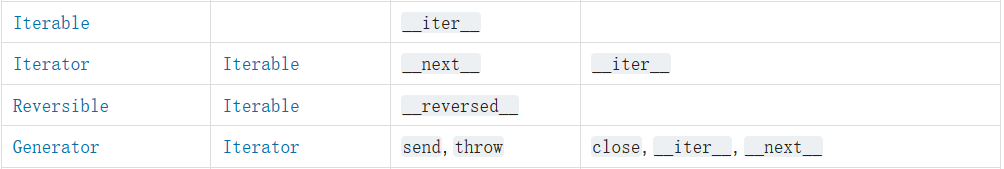

《流畅的python》中对可迭代对象，迭代器，生成器，生成器对象的定义和描述非常清晰和准确，总结如下：
1. 没有迭代器，可迭代对象这样的类型（type），所谓迭代器，可迭代对象只是实现了特殊方法的类，内置的`issubclass`,`isinstance`也是这样判断的。
2. 包含`__iter__`特殊方法，并且返回一个迭代器的类的实例，就是一个可迭代对象。
3. 包含`__iter__`和`__next__`特殊方法的类的实例，就是一个迭代器，迭代器中的`__iter__`特殊方法返回自身，这不是必须，是约定如此，这样迭代器本身也是一个可迭代对象，可以在需要可迭代对象的环境中，比如`for`循环中使用。但是注意：可迭代对象和迭代器的`__iter__`返回是不同的，可迭代对象可以“生产”多个迭代器，而迭代器只能返回其本身。也就是说，可迭代对象是迭代器的工厂。
4. 带`yield`关键字的是生成器函数，执行生成器函数会返回一个生成器对象，因此生成器函数是生成器对象的工厂。
5. 生成器对象是一个迭代器，在内部对生成器函数进行了包装，每次调用`__next__`的时候，在`__next__`内部推动生成器函数执行下一步，从而产出或者说生成值返回。虽然生成器对象是一个迭代器，使用起来都一样，但是打印生成器对象显示为`generator object`，打印迭代器显示为`iterator object`。

以上只是从接口和实现方式角度区分迭代器和生成器，更广泛一点，从概念上又有所不同，《流畅的python》生成器和迭代器一章的延伸阅读有详细的阐述。

### 生成器的`throw`和`close`方法

生成器有`throw`和`close`方法，平时用的不多，但是理解它们可以更深刻的理解生成器，主要要注意两点：
- `generator.throw(exc_type[, exc_value[, traceback]])`：致使生成器在暂停的`yield`表达式处抛出指定的异常。如果生成器处理了抛出的异常，代码会向前执行到下一个`yield`表达式，而产出的值会成为调用`generator.throw`方法得到的返回值。如果生成器没有处理抛出的异常，异常会向上冒泡，传到调用方的上下文中。
- `generator.close()`：致使生成器在暂停的`yield`表达式处抛出`GeneratorExit`异常。如果生成器没有处理这个异常，或者抛出了`StopIteration`异常（通常是指运行到结尾），调用方不会报错。如果收到`GeneratorExit`异常，生成器一定不能产出值，否则解释器会抛出`RuntimeError`异常。生成器抛出的其他异常会向上冒泡，传给调用方。

### 深入理解`yield from` 

在介绍`yield from`之前，先稍微回顾一下普通的生成器（协程）的处理机制，如下的生成器：

In [229]:
def c():
    yield 1
    yield 2
    return 42

g = c()
print(next(g)) # 激活生成器
print(next(g))
try:
    next(g)
except StopIteration as e:
    print(e.value)

1
2
42
